In [28]:
from qiskit import *
import numpy as np
#import pylab as pl
import networkx as nx
import random as ran
from qiskit.visualization import *
import qiskit.tools.jupyter
import matplotlib as ml
%qiskit_version_table
%qiskit_copyright

Defining the randomCircuit() function:

In [89]:
def randomCircuit(G,cnots=0, depth=0): #Either cnots or depth can be zero, which means "unspecified".
    V = list(G.nodes)
    num_V = len(V)
    L = nx.line_graph(G)
    MI = nx.maximal_independent_set(L)
    #print('MI:  ', MI)
    q = QuantumRegister(num_V)
    c = ClassicalRegister(num_V)
    circ = QuantumCircuit(q,c)
    circ.barrier()
    ran.seed()
    #copy of circuit for internal tracing:
    cc = []
    for j in V:
        cc.append([])
    dd = []
    for j in V:
        dd.append(0)

    #begin construction:
    if (cnots and depth):
        if (2*cnots + 1 < depth):
            print("Impossible circuit parameters: number of CNOTs is too low to reach the desired depth. Try again with different parameters.")
        elif (depth*len(MI) < cnots):
            print("Impossible circuit parameters: depth is too low to fit all the required CNOTs into the given graph. Try again with different parameters.")
        else:
            print("Constructing circuit with ", cnots, " CNOTs and ", depth," depth...")

            #preconstruction:
            for j in V:
                for d in range(depth):
                    cc[j].append(0)
            print('Preconstruction...')
            
            k = 0
            sparse = True
            contin = True

            #adding CNOT gates:
            while (sparse):
                n = 0
                cc = []
                for j in V:
                    cc.append([])
                for j in V:
                    for d in range(depth):
                        cc[j].append(0)
                #print('new attempt:', k)
                if (k > 100*cnots*depth*depth):
                    print("Sorry, unable to construct the circuit after ", k, " attempts. Try again with different parameters.")
                    contin = False
                    break
                while (n < cnots):
                    k +=1
                    if (k > 100*cnots*depth*depth):
                        break
                    edge = ran.sample(G.edges(),1)[0]
                    node1 = edge[0]
                    node2 = edge[1]
                    d = ran.randint(0,depth-1)
                    
                    if (cc[node1][d] == 0 and cc[node2][d] == 0):
                        if ran.choice([0,1]):                   
                            cc[node1][d] = ['C', node2]
                            cc[node2][d] = 'X'
                        else:
                            cc[node2][d] = ['C', node1]
                            cc[node1][d] = 'X'
                        n +=1
                
                #check if circuit is too sparse
                unsparse = False
                for j in V:
                    sparsehere = False
                    for d in range(depth-1):
                        if (cc[j][d] == 0 and cc[j][d+1] == 0):
                            sparsehere = True
                            break
                    if not(sparsehere):
                        unsparse = True
                if (unsparse):
                    sparse = False
                
            #print('cc looks like this:')
            #print(cc)
            #actual construction:
            if (contin):
                print('Successful at attempt ', k)
                print('Constructing circuit...')
                for j in V:
                    if (isinstance(cc[j][0],list)):
                        if (cc[j][0][0] == 'C'):
                            if (cc[cc[j][0][1]][0] == 'X'):
                                circ.cx(j,cc[j][0][1])
                    elif (cc[j][0] == 0):
                        theta = ran.uniform(0.0, 2*np.pi)
                        phi = ran.uniform(0.0, 2*np.pi)
                        lam = ran.uniform(0.0, 2*np.pi)
                        circ.u3(theta, phi, lam, j)
                        
                for d in range(1,depth):
                    circ.barrier()
                    for j in V:
                        if (isinstance(cc[j][d],list)):
                            if (cc[j][d][0] == 'C'):
                                if (cc[cc[j][d][1]][d] == 'X'):
                                    circ.cx(j,cc[j][d][1])
                        elif ((cc[j][d] == 0) and (cc[j][d-1] != 0)):
                            theta = ran.uniform(0.0, 2*np.pi)
                            phi = ran.uniform(0.0, 2*np.pi)
                            lam = ran.uniform(0.0, 2*np.pi)
                            circ.u3(theta, phi, lam, j)
                            
                          
    elif (cnots and not(depth)):
        print("Constructing circuit with ", cnots, " CNOTs and arbitrary depth...")
        n = 0
        while (n < cnots):
            gate=ran.choice(['CX','U3']) #choose randomly between CNOT and U3
            if (gate == 'U3'):
                node = ran.choice(range(num_V))
                if (not(cc[node]) or (cc[node][-1] != 'U3')):
                    theta = ran.uniform(0.0, 2*np.pi)
                    phi = ran.uniform(0.0, 2*np.pi)
                    lam = ran.uniform(0.0, 2*np.pi)
                    circ.u3(theta, phi, lam, node)
                    cc[node].append('U3')
            else:
                n += 1
                edge = ran.sample(G.edges(),1)[0]
                node1 = edge[0]
                node2 = edge[1]
                if ran.choice([0,1]):
                    circ.cx(node1,node2)
                    cc[node1].append('C')
                    cc[node2].append('X')
                else:
                    circ.cx(node2,node1)
                    cc[node2].append('C')
                    cc[node1].append('X')
    elif (not(cnots) and depth):
        print("Constructing circuit with arbitrarly many CNOTs and ", depth," depth...")
        d = 0
        while(d < depth):
            gate=ran.choice(['CX','U3']) #choose randomly between CNOT and U3
            if (gate == 'U3'):
                node = ran.choice(range(num_V))
                if (not(cc[node]) or (cc[node][-1] != 'U3')):
                    theta = ran.uniform(0.0, 2*np.pi)
                    phi = ran.uniform(0.0, 2*np.pi)
                    lam = ran.uniform(0.0, 2*np.pi)
                    circ.u3(theta, phi, lam, node)
                    cc[node].append('U3')
                    dd[node] += 1
            else:
                edge = ran.sample(G.edges(),1)[0]
                node1 = edge[0]
                node2 = edge[1]
                if ran.choice([0,1]):
                    circ.cx(node1,node2)
                    cc[node1].append('C')
                    cc[node2].append('X')
                else:
                    circ.cx(node2,node1)
                    cc[node2].append('C')
                    cc[node1].append('X')
                dd[node1] += 1
                dd[node2] += 1
                dd[node1] = max(dd[node1],dd[node2])
                dd[node2] = dd[node1]
            d = max(dd)
            #print(d)
    else:
        print("This will only return an empty circuit.")
    circ.barrier()
    circ.measure(q,c)
    return circ

To describe the arquitecture of the quantum engine, we construct a graph using networkx.
Edges can be weighted to reflect CNOT error rates. Otherwise their weights should be 1.0 (which is "neutral").

In [74]:
#Example:
V = np.arange(0,5,1)
E =[(0,1,1.0),(1,2,1.0),(2,3,1.0),(3,4,1.0),(4,5,1.0),(3,5,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

Here is a little selection of IBMs quantum engines as graphs:

In [75]:
V_ibmq_london = np.arange(5)
E_ibmq_london = [(0,1,1.0),(1,2,1.0),(1,3,1.0),(3,4,1.0)]
G_ibmq_london = nx.Graph()
G_ibmq_london.add_nodes_from(V_ibmq_london)
G_ibmq_london.add_weighted_edges_from(E_ibmq_london)

V_ibmq_5_yorktown = np.arange(5)
E_ibmq_5_yorktown = [(0,1,1.0),(0,2,1.0),(1,2,1.0),(2,3,1.0),(2,4,1.0),(3,4,1.0)]
G_ibmq_5_yorktown = nx.Graph()
G_ibmq_5_yorktown.add_nodes_from(V_ibmq_5_yorktown)
G_ibmq_5_yorktown.add_weighted_edges_from(E_ibmq_5_yorktown)

V_ibmq_16_melbourne = np.arange(15)
E_ibmq_16_melbourne = [(0,1,1.0),(1,2,1.0),(2,3,1.0),(3,4,1.0),(4,5,1.0),(5,6,1.0),(6,8,1.0),(7,8,1.0),(8,9,1.0),(9,10,1.0),(10,11,1.0),(11,12,1.0),(12,13,1.0),(13,14,1.0),(0,14,1.0),(1,13,1.0),(2,12,1.0),(3,11,1.0),(4,10,1.0),(5,9,1.0)]
G_ibmq_16_melbourne = nx.Graph()
G_ibmq_16_melbourne.add_nodes_from(V_ibmq_16_melbourne)
G_ibmq_16_melbourne.add_weighted_edges_from(E_ibmq_16_melbourne)

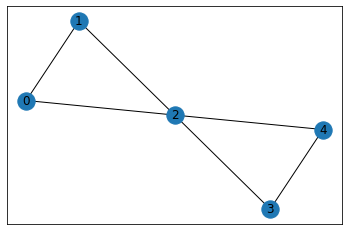

In [76]:
nx.draw_networkx(G_ibmq_5_yorktown)

To generate a random circuit, we use the randomCircuit() function. 
It takes the graph describing the quantum engine as its first argument.

This will only return an empty circuit.


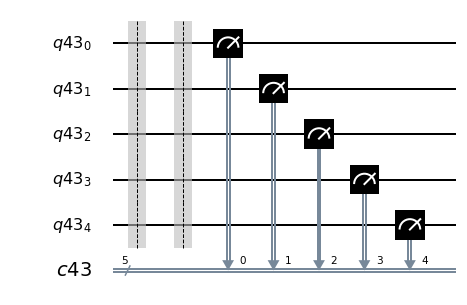

In [77]:
circ = randomCircuit(G_ibmq_5_yorktown)
circ.draw(output='mpl')

However, we did not specify that we want to have any gates in the circuit. To do that, we can set the number of CNOTs.

Constructing circuit with  9  CNOTs and arbitrary depth...


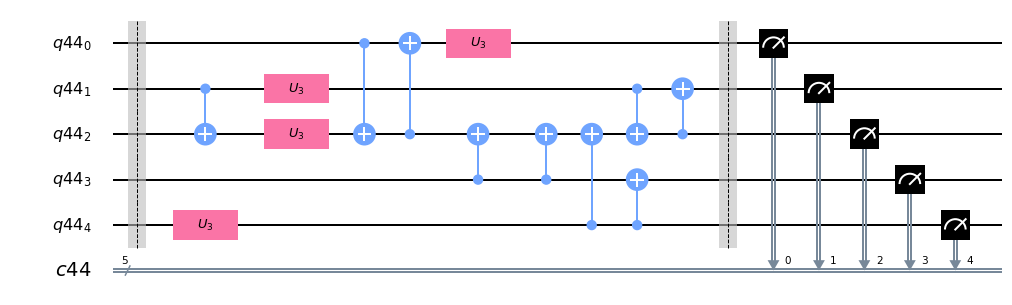

In [78]:
circ = randomCircuit(G_ibmq_5_yorktown, cnots=9)
circ.draw(output='mpl')

We can also specify the depth instead of the number of CNOTs:

Constructing circuit with arbitrarly many CNOTs and  10  depth...


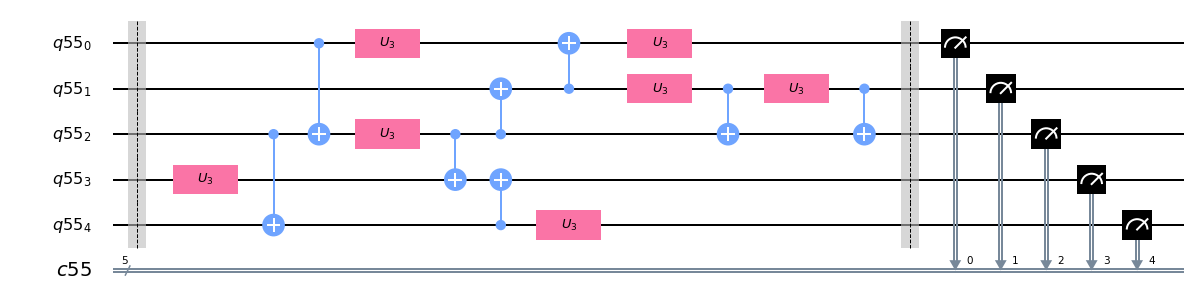

In [92]:
circ = randomCircuit(G_ibmq_5_yorktown, depth=10)
circ.draw(output='mpl')

If we specify both parameters, the algorithm will first try to determine if the chosen configuration is possible:

Impossible circuit parameters: depth is too low to fit all the required CNOTs into the given graph. Try again with different parameters.


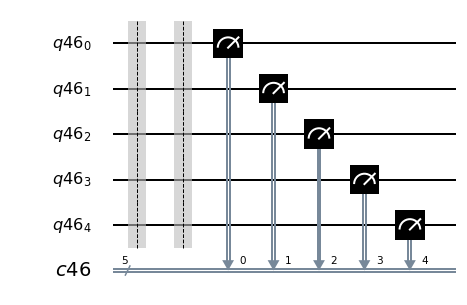

In [80]:
circ = randomCircuit(G_ibmq_5_yorktown, cnots=13, depth=2)
circ.draw(output='mpl')

Impossible circuit parameters: number of CNOTs is too low to reach the desired depth. Try again with different parameters.


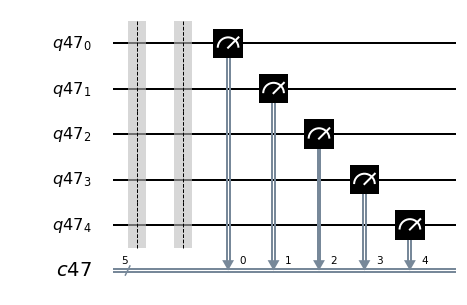

In [81]:
circ = randomCircuit(G_ibmq_5_yorktown, cnots=3, depth=9)
circ.draw(output='mpl')

If it is indeed possible, it will construct a random circuit with the given depth and number of CNOTs:

Constructing circuit with  14  CNOTs and  9  depth...
Preconstruction...
Successful at attempt  90
Constructing circuit...


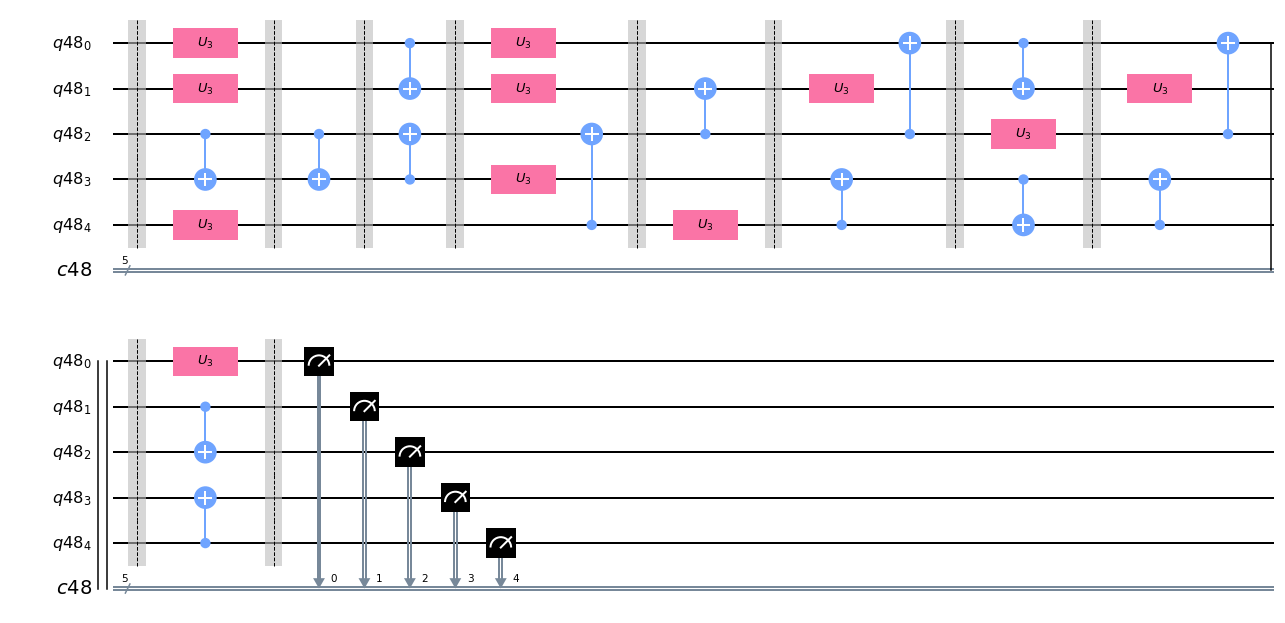

In [82]:
circ = randomCircuit(G_ibmq_5_yorktown, cnots=14, depth=9)
circ.draw(output='mpl')

Depending on the parameters, construction can take a while. This is because the algorithm has to generate lots of random circuits until one of them fits the specifications.
Sometimes it will simply give up after a large number of tries.

Constructing circuit with  16  CNOTs and  33  depth...
Preconstruction...
Sorry, unable to construct the circuit after  1742401  attempts. Try again with different parameters.


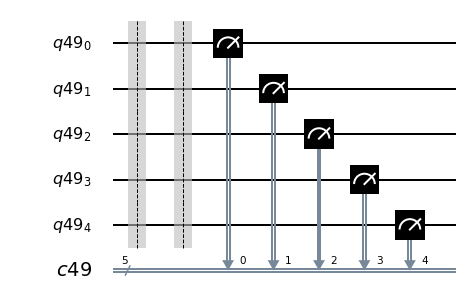

In [83]:
circ = randomCircuit(G_ibmq_5_yorktown, cnots=16, depth=33)
circ.draw(output='mpl')